In [1]:
import os
os.environ['HF_HOME'] = '/workspace/cache/huggingface/'
os.chdir('/workspace/FutureGPT2/src/')

import numpy as np
from torch import optim, nn, Tensor
from torch.nn import functional as F
import torch
import wandb
from transformers import GPT2Config, GPT2Model, AutoTokenizer, AutoModelForCausalLM
import transformers
import lightning as L
from inspect import signature, _ParameterKind
import copy
import gc
import datasets
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import WandbLogger
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm
from itertools import repeat, product
import matplotlib.pyplot as plt


from models.gpt_model import *
from models.myopic_model import *
from data.arithmetic import *
from models.myopic_model import to_myopic_gpt2

%load_ext autoreload
%autoreload 2

In [2]:
model_name = 'gpt2'
tokenizer = AutoTokenizer.from_pretrained(model_name)
Token = {v: k for k, v in tokenizer.get_vocab().items()}

In [28]:
def to_str(tokens):
    return ''.join(Token[x.item()] for x in tokens).replace('Ġ', ' ')

In [73]:
def get_acc(model, max_digits, pad):
    acc = dict()
    for x_digits, y_digits in tqdm(product(range(1, max_digits+1), range(1, max_digits+1)), total=max_digits**2):
        val = DataLoader(
            MultiplicationDataset(
                size=1024,
                x_min_digits=x_digits,
                x_max_digits=x_digits,
                y_min_digits=y_digits,
                y_max_digits=y_digits,
                x_pad=pad,
                y_pad=pad,
                tokenizer=tokenizer
            ), 
            batch_size=1024,
        )
        batch = next(iter(val))
        sample = batch['input_ids'][0]
        pre = sample[:pad*2+2]
        suf = sample[pad*2+2:]
        print(x_digits, y_digits)
        print(to_str(pre) + '|' + to_str(suf))
        input = batch['input_ids'].to('cuda')
        out = model.generate(
            input[:,:pad*2+2], 
            max_length=pad+pad+x_digits+y_digits+2,
            attention_mask=torch.ones(input[:,:2*pad+2].shape, device=input.device),
            pad_token_id=tokenizer.eos_token_id,
        )
        print(to_str(out[0]))
        acc[(x_digits, y_digits)] = (out == input).all(dim=1).to(torch.float).mean().item()
    return acc

In [68]:
def plot_acc(acc, max_digits):
    acc_str = [
        [f'{acc[(y+1, x+1)]:.2f}' for x in range(max_digits)] for y in range(max_digits)
    ]
    
    fig, ax = plt.subplots()
    table = ax.table(
        cellText=acc_str, 
        loc='center', 
        cellLoc='center', 
        colWidths=[0.15 for _ in range(max_digits)],
        colLabels=range(1, max_digits+1),
        rowLabels=range(1, max_digits+1),
    )
    
    for i in range(max_digits):
        for j in range(max_digits):
            color = plt.cm.viridis(acc[(i+1,j+1)])
            table[(i+1, j)].set_facecolor(color)
            if acc[(i+1,j+1)] < 0.5:
                table[(i+1, j)].set_text_props(color='white')
    ax.axis('off')
    plt.show()

In [121]:
#state_dict = torch.load('/workspace/checkpoints/ARITH_GPT2_MAX8_REVERSE_RANDINIT_global_step=19531.0_train_loss=0.74.ckpt')['state_dict']
#state_dict = torch.load('/workspace/checkpoints/ARITH_GPT2_MAX5_PAD5_REVERSE_RANDINIT_global_step=3509.0_train_loss=0.41.ckpt')['state_dict']
state_dict = torch.load(
    #'/workspace/checkpoints/ARITH_GPT2_MAX5_PAD5_REVERSE_RANDINIT_global_step=9759.0_train_loss=0.01.ckpt'
    #'/workspace/checkpoints/ARITH_GPT2_MAX5_PAD10_REVERSE_RANDINIT_global_step=9759.0_train_loss=0.00.ckpt',
    #'/workspace/checkpoints/ARITH_GPT2_MYOPIC_MAX5_PAD5_REVERSE_RANDINIT_global_step=8783.0_train_loss=0.04.ckpt',
    '/workspace/checkpoints/ARITH_GPT2_MYOPIC_MAX5_PAD10_REVERSE_RANDINIT_global_step=8783.0_train_loss=0.07.ckpt',
)['state_dict']
model = AutoModelForCausalLM.from_pretrained('gpt2')
model.load_state_dict({'.'.join(k.split('.')[1:]): v for k, v in state_dict.items()}, strict=False)
model = model.to('cuda')

In [123]:
acc = get_acc(model, 5, 10)

  0%|          | 0/25 [00:00<?, ?it/s]

1 1
 6 0 0 0 0 0 0 0 0 0 * 7 0 0 0 0 0 0 0 0 0 =| 2 4
 6 0 0 0 0 0 0 0 0 0 * 7 0 0 0 0 0 0 0 0 0 = 2 4
1 2
 8 0 0 0 0 0 0 0 0 0 * 4 5 0 0 0 0 0 0 0 0 =| 2 3 4
 8 0 0 0 0 0 0 0 0 0 * 4 5 0 0 0 0 0 0 0 0 = 2 3 4
1 3
 4 0 0 0 0 0 0 0 0 0 * 3 2 4 0 0 0 0 0 0 0 =| 2 9 6 1
 4 0 0 0 0 0 0 0 0 0 * 3 2 4 0 0 0 0 0 0 0 = 2 9 6 1
1 4
 0 0 0 0 0 0 0 0 0 0 * 7 5 1 9 0 0 0 0 0 0 =| 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 * 7 5 1 9 0 0 0 0 0 0 = 0 0 0 0 0
1 5
 3 0 0 0 0 0 0 0 0 0 * 0 1 3 9 1 0 0 0 0 0 =| 0 3 9 7 5 0
 3 0 0 0 0 0 0 0 0 0 * 0 1 3 9 1 0 0 0 0 0 = 0 3 9 7 5 0
2 1
 4 8 0 0 0 0 0 0 0 0 * 7 0 0 0 0 0 0 0 0 0 =| 8 8 5
 4 8 0 0 0 0 0 0 0 0 * 7 0 0 0 0 0 0 0 0 0 = 8 8 5
2 2
 8 9 0 0 0 0 0 0 0 0 * 2 1 0 0 0 0 0 0 0 0 =| 6 7 1 1
 8 9 0 0 0 0 0 0 0 0 * 2 1 0 0 0 0 0 0 0 0 = 6 7 1 1
2 3
 1 3 0 0 0 0 0 0 0 0 * 0 9 0 0 0 0 0 0 0 0 =| 0 9 7 2 0
 1 3 0 0 0 0 0 0 0 0 * 0 9 0 0 0 0 0 0 0 0 = 0 9 7 2 0
2 4
 9 6 0 0 0 0 0 0 0 0 * 7 3 3 5 0 0 0 0 0 0 =| 3 5 2 8 6 3
 9 6 0 0 0 0 0 0 0 0 * 7 3 3 5 0 0 0 0 0 0 = 3 5 2

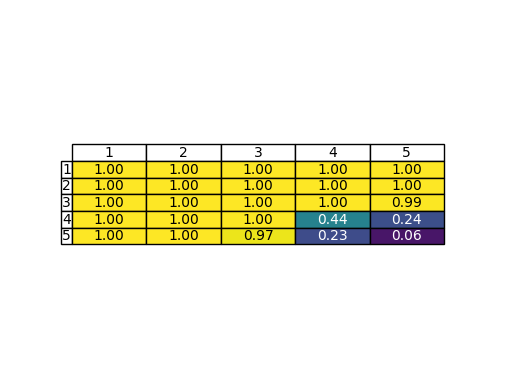

In [124]:
plot_acc(acc, 5)

In [96]:
lit_model = LitGPTModel.load_from_checkpoint(
    '/workspace/checkpoints/ARITH_GPT2_MAX5_PAD10_REVERSE_RANDINIT_global_step=9759.0_train_loss=0.00.ckpt',
)

In [77]:
val = DataLoader(
    MultiplicationDataset(
        size=1024, 
        x_min_digits=5,
        y_min_digits=5,
        x_max_digits=5,
        y_max_digits=5,
        x_pad=10,
        y_pad=10,
        tokenizer=tokenizer
    ), 
    batch_size=1024,
    #num_workers=254,
)

In [78]:
batch = next(iter(val))
batch['input_ids'] = batch['input_ids'].to('cuda')

In [79]:
to_str(batch['input_ids'][0])

' 1 0 5 1 7 0 0 0 0 0 * 4 2 1 9 2 0 0 0 0 0 = 4 2 1 5 9 3 2 8 0 2'

In [80]:
x = batch['input_ids']
x_cut = x[:,:model.acc_cutoff]
out = model.model.generate(
    x_cut, max_length=x.shape[-1],
    attention_mask=torch.ones(x_cut.shape, device=x.device),
    pad_token_id=50256, # tokenizer.eos_token_id
    use_cache=False, # for compatibility with myopic model
)
print(to_str(x[0]))
print(to_str(x_cut[0]))
print(to_str(out[0]))
print((out == x).all(dim=1).to(torch.float).mean())

 1 0 5 1 7 0 0 0 0 0 * 4 2 1 9 2 0 0 0 0 0 = 4 2 1 5 9 3 2 8 0 2
 1 0 5 1 7 0 0 0 0 0 * 4 2 1 9 2 0 0 0 0 0 =
 1 0 5 1 7 0 0 0 0 0 * 4 2 1 9 2 0 0 0 0 0 = 4 2 1 5 9 3 2 8 0 2
tensor(0.8271, device='cuda:0')


In [85]:
pad = 10
x_digits = 5
y_digits = 5
val = DataLoader(
        MultiplicationDataset(
            size=1024,
            x_min_digits=x_digits,
            x_max_digits=x_digits,
            y_min_digits=y_digits,
            y_max_digits=y_digits,
            x_pad=pad,
            y_pad=pad,
            tokenizer=tokenizer
        ), 
        batch_size=1024,
)
out = model.model.generate(
    x[:,:pad*2+2], 
    max_length=pad+pad+x_digits+y_digits+2,
    attention_mask=torch.ones(x[:,:2*pad+2].shape, device=x.device),
    pad_token_id=tokenizer.eos_token_id,
)
print(to_str(out[0]))
print((out == x).all(dim=1).to(torch.float).mean())

 1 0 5 1 7 0 0 0 0 0 * 4 2 1 9 2 0 0 0 0 0 = 4 2 1 5 9 3 2 8 0 2
tensor(0.8115, device='cuda:0')


In [87]:
(out == x).all(dim=1).to(torch.float).mean().item()

0.8115234375

In [111]:
lit_model.model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [112]:
val = DataLoader(
    MultiplicationDataset(
        size=1024,
        x_min_digits=x_digits,
        x_max_digits=x_digits,
        y_min_digits=y_digits,
        y_max_digits=y_digits,
        x_pad=pad,
        y_pad=pad,
        tokenizer=tokenizer
    ), 
    batch_size=1024,
)
batch = next(iter(val))
sample = batch['input_ids'][0]
pre = sample[:pad*2+2]
suf = sample[pad*2+2:]
print(x_digits, y_digits)
print(to_str(pre) + '|' + to_str(suf))
input = batch['input_ids'].to('cuda')
out = lit_model.model.generate(
    input[:,:pad*2+2], 
    max_length=pad+pad+x_digits+y_digits+2,
    attention_mask=torch.ones(input[:,:2*pad+2].shape, device=input.device),
    pad_token_id=tokenizer.eos_token_id,
)
print(to_str(out[0]))
(out == input).all(dim=1).to(torch.float).mean().item()

5 5
 1 4 1 7 0 0 0 0 0 0 * 4 2 3 1 5 0 0 0 0 0 =| 4 8 6 4 0 5 6 6 3 0
 1 4 1 7 0 0 0 0 0 0 * 4 2 3 1 5 0 0 0 0 0 = 4 8 6 4 0 5 6 6 3 0


0.9853515625

In [92]:
model.model.dtype

torch.float32

In [97]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [102]:
lit_model.model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [106]:
model.transformer.h[5].attn.c_attn.weight

Parameter containing:
tensor([[-0.0180,  0.0137,  0.0147,  ..., -0.0123,  0.0064,  0.0107],
        [ 0.0230,  0.0045,  0.0110,  ...,  0.0075,  0.0079, -0.0317],
        [-0.0324, -0.0106, -0.0046,  ..., -0.0034, -0.0275, -0.0051],
        ...,
        [ 0.0119,  0.0001,  0.0196,  ..., -0.0068,  0.0082,  0.0130],
        [ 0.0215,  0.0026,  0.0178,  ..., -0.0088,  0.0095,  0.0053],
        [ 0.0101,  0.0204,  0.0243,  ...,  0.0207, -0.0403,  0.0116]],
       device='cuda:0', requires_grad=True)

In [109]:
(lit_model.model.transformer.h[5].attn.c_attn.weight == model.transformer.h[5].attn.c_attn.weight).all()

tensor(True, device='cuda:0')